# Converting a Circuit to an MPO

This example shows how to convert a quantum circuit (that is sufficiently shallow) into a matrix product operator (MPO).

In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn

First we generate some random 1D gates:

In [2]:
gates = qtn.circuit_gen.gates_1D_rand(10, depth=8, seed=42)

Then we construct the [`Circuit`](quimb.tensor.circuit.Circuit):

In [3]:
circ = qtn.Circuit.from_gates(
    gates,
    # this ensure each tensor belongs to one site only
    gate_contract="split-gate",
    # just for cleaner tags
    tag_gate_numbers=False,
)

Next we extract just the unitary part of the tensor network:

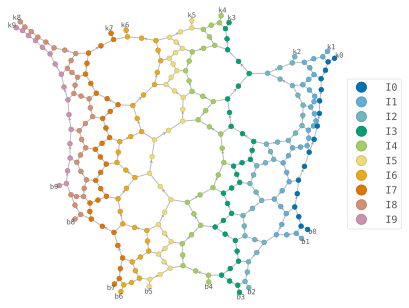

In [4]:
tn_uni = circ.get_uni()
tn_uni.draw(tn_uni.site_tags, show_tags=False)

## By direct contraction:

Then we contract each group of tensor associate with each site (color above):

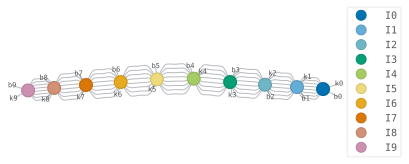

In [5]:
for site in tn_uni.site_tags:
    tn_uni ^= site

tn_uni.draw(tn_uni.site_tags, show_tags=False)

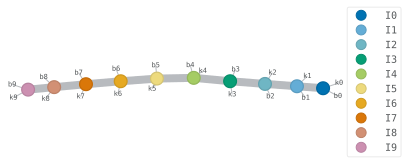

In [6]:
tn_uni.fuse_multibonds_()
tn_uni.draw(tn_uni.site_tags, show_tags=False)

Now it has the form of an MPO, we can cast it the actual [`MatrixProductOperator`](quimb.tensor.tensor_1d.MatrixProductOperator) class:

In [7]:
tn_uni.view_as_(
    qtn.MatrixProductOperator,
    cyclic=False,
    L=circ.N,
)

MatrixProductOperator(tensors=10, indices=29, L=10, max_bond=256)

```{hint}
You may want or need to call the [`ensure_bonds_exist`](quimb.tensor.tensor_1d.TensorNetwork1DFlat.ensure_bonds_exist) method at this point if there were not bonds connecting all adjacent tensors in the circuit.
```

This allows us to call MPO specific methods.

In [8]:
tn_uni.compress(cutoff=1e-6, cutoff_mode="rel")
tn_uni.show()

│4│16│64│128│125│128│64│16│4│
●─<──<──<━━━<━━━<━━━<──<──<─<
│ │  │  │   │   │   │  │  │ │


## By fitting

An alternative approach that will scale better, especially if a fixed `max_bond` is known ahead of time is to directly fit a low-rank 1D TN to the unitary:

In [9]:
# get a fresh (uncontracted) TN representation of the circuit
tn_uni = circ.get_uni()

In [10]:
# compress via fitting:
tnc = qtn.tensor_network_1d_compress(
    tn_uni,
    max_bond=32,
    cutoff=0.0,
    method="fit",
    bsz=2,  # bsz=1 is cheaper per sweep, but possibly slower to converge
    max_iterations=100,
    tol=1e-6,
    progbar=True,
)

max_tdiff=8.62e-07:   8%|8         | 8/100 [00:01<00:14,  6.56it/s]


Compute relative frobenius norm error:

In [11]:
tnc.distance_normalized(tn_uni)

np.float64(0.09292853617632899)

In [12]:
# againt cast as MPO if we want more methods
tnc.view_as_(
    qtn.MatrixProductOperator,
    cyclic=False,
    L=circ.N,
)

MatrixProductOperator(tensors=10, indices=29, L=10, max_bond=32)

In [13]:
tnc.show()

│4│16│32│32│32│32│32│16│4│
>─>──>──>──>──>──>──>──>─●
│ │  │  │  │  │  │  │  │ │
